## Import Library and Dataset:

In [100]:
import os
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torch.optim import lr_scheduler

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import copy

import gc

gc.collect()

torch.cuda.empty_cache()

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
data_transforms = {
    'seg_train/seg_train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'seg_test/seg_test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './intel/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['seg_train/seg_train', 'seg_test/seg_test']}

train_sizes = len(image_datasets['seg_train/seg_train'])
test_sizes = len(image_datasets['seg_test/seg_test']) 

class_names = image_datasets['seg_train/seg_train'].classes
print(class_names)

['buildings', 'forest', 'mountain']


In [4]:
art_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

art_dir = './'
art_datasets = {x: datasets.ImageFolder(os.path.join(art_dir, x), art_transforms[x]) for x in ['train', 'test']}

train_sizes = len(art_datasets['train']) 
test_sizes = len(art_datasets['test']) 

art_names = art_datasets['train'].classes
print(art_names)

['building', 'forest', 'mountain']


In [6]:
# load data                  
art_train_dataset = DataLoader(art_datasets['train'], batch_size=16,shuffle=True)
art_test_dataset = DataLoader(art_datasets['test'], batch_size=16,shuffle=True)

In [7]:
train_dataset = DataLoader(image_datasets['seg_train/seg_train'], batch_size=32,shuffle=True)
test_dataset = DataLoader(image_datasets['seg_test/seg_test'], batch_size=32,shuffle=True)

In [8]:
for X, y in art_train_dataset:
    print(X.shape)
    break

torch.Size([16, 3, 224, 224])


## Denoise using autoencoder:

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder= nn.Sequential(
            nn.Conv2d(3,16,3,stride=2,padding=1), 
            nn.ReLU(),
            nn.Conv2d(16,32,3,stride=2,padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64,5),
            nn.ReLU()        
        )
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(64,32,5),
            nn.ReLU(),
            nn.ConvTranspose2d(32,16,3,stride=2,padding=1,output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16,3,3,stride=2,padding=1,output_padding=1), 
            nn.Sigmoid()

        )
    def forward(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [200]:
denoise_model = Autoencoder()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(denoise_model.parameters(),lr=0.001)

Epoch 1/20
 Loss: 8.7863 
Epoch 2/20
 Loss: 6.0069 
Epoch 3/20
 Loss: 4.9016 
Epoch 4/20
 Loss: 4.6338 
Epoch 5/20
 Loss: 4.4415 
Epoch 6/20
 Loss: 4.2389 
Epoch 7/20
 Loss: 4.0234 
Epoch 8/20
 Loss: 4.0692 
Epoch 9/20
 Loss: 3.9897 
Epoch 10/20
 Loss: 3.9549 
Epoch 11/20
 Loss: 4.0225 
Epoch 12/20
 Loss: 3.8698 
Epoch 13/20
 Loss: 3.9050 
Epoch 14/20
 Loss: 3.6986 
Epoch 15/20
 Loss: 3.8602 
Epoch 16/20
 Loss: 3.9222 
Epoch 17/20
 Loss: 3.7741 
Epoch 18/20
 Loss: 3.8045 
Epoch 19/20
 Loss: 3.6530 
Epoch 20/20
 Loss: 3.7235 


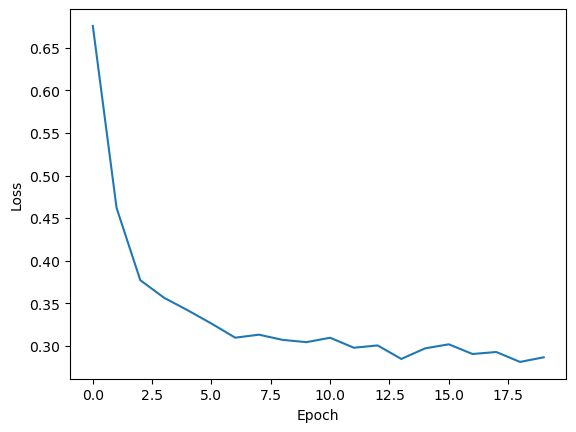

In [173]:
losses = []
epoch_loss =0 
for epoch in range(20):
    for X,y in art_train_dataset:
        reconstruction = denoise_model(X)
        loss = loss_function(reconstruction,X)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss/len(art_train_dataset))
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f' Loss: {epoch_loss:.4f} ')
    epoch_loss=0
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.plot(losses)

In [ ]:
model_vgg16_denoise = models.vgg16(weights='DEFAULT').to(device)
for param in model_vgg16_denoise.features.parameters():
    param.requires_grad = False
model_vgg16_denoise.classifier[6] = nn.Linear(model_vgg16_denoise.classifier[6].in_features, len(art_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_vgg16_denoise.classifier.parameters(), lr=0.005, momentum=0.9)

In [199]:
epochs = 15
best_acc = 0.0

for epoch in range(epochs):
    # train data
    model_vgg16_denoise.train()  
    for X, y in art_train_dataset:
        X = denoise_model(X)
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        outputs = model_vgg16_denoise(X)
        loss = criterion(outputs, y)
        # backward + optimize 
        loss.backward()
        optimizer.step()

    # valid data
    valid_loss = 0.0
    correct = 0
    model_vgg16_denoise.eval()
    # Iterate over data.
    for X, y in art_test_dataset:
        X = denoise_model(X)
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # forward
        outputs = model_vgg16_denoise(X)
        loss = criterion(outputs, y)
        valid_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y) 
    
    epoch_loss = valid_loss / len(art_test_dataset)
    epoch_acc = correct / (len(art_test_dataset) * 32)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f' Loss: {epoch_loss:.4f} Acc: {epoch_acc:.3f}')
    if epoch_acc >= best_acc:
        best_acc = epoch_acc
        torch.save(model_vgg16_denoise.state_dict(), 'freezed_vgg16_model.pt')

Epoch 1/15
 Loss: 1.4134 Acc: 0.172
Epoch 2/15
 Loss: 1.0984 Acc: 0.203
Epoch 3/15
 Loss: 1.0484 Acc: 0.273
Epoch 4/15
 Loss: 0.9166 Acc: 0.242
Epoch 5/15
 Loss: 1.0073 Acc: 0.227
Epoch 6/15
 Loss: 1.0803 Acc: 0.219
Epoch 7/15
 Loss: 1.3459 Acc: 0.164
Epoch 8/15
 Loss: 1.2810 Acc: 0.195
Epoch 9/15
 Loss: 1.1469 Acc: 0.242
Epoch 10/15
 Loss: 1.1189 Acc: 0.258
Epoch 11/15
 Loss: 1.3225 Acc: 0.219
Epoch 12/15
 Loss: 1.1539 Acc: 0.250
Epoch 13/15
 Loss: 1.1600 Acc: 0.258
Epoch 14/15
 Loss: 1.2885 Acc: 0.227
Epoch 15/15
 Loss: 1.3650 Acc: 0.234


## Model: VGG16

### Transfer learning directly:

#### Freezed Model:

In [74]:
model_vgg16 = models.vgg16(weights='DEFAULT').to(device)
for param in model_vgg16.features.parameters():
    param.requires_grad = False
model_vgg16.classifier[6] = nn.Linear(model_vgg16.classifier[6].in_features, len(art_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_vgg16.classifier.parameters(), lr=0.0005)

In [76]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [77]:
epochs = 15
best_acc = 0.0

for epoch in range(epochs):
    # train data
    model_vgg16.train()  
    for X, y in art_train_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        outputs = model_vgg16(X)
        loss = criterion(outputs, y)
        # backward + optimize 
        loss.backward()
        optimizer.step()

    # valid data
    valid_loss = 0.0
    correct = 0
    model_vgg16.eval()
    # Iterate over data.
    for X, y in art_test_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # forward
        outputs = model_vgg16(X)
        loss = criterion(outputs, y)
        valid_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y) 
    
    epoch_loss = valid_loss / len(art_test_dataset)
    epoch_acc = correct / (len(art_test_dataset) * 32)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f' Loss: {epoch_loss:.4f} Acc: {epoch_acc:.3f}')
    if epoch_acc >= best_acc:
        best_acc = epoch_acc
        torch.save(model_vgg16.state_dict(), 'freezed_vgg16_model.pt')

Epoch 1/15
 Loss: 0.5634 Acc: 0.344
Epoch 2/15
 Loss: 0.4203 Acc: 0.383
Epoch 3/15
 Loss: 0.4454 Acc: 0.391
Epoch 4/15
 Loss: 0.4028 Acc: 0.391
Epoch 5/15
 Loss: 0.3884 Acc: 0.391
Epoch 6/15
 Loss: 0.3187 Acc: 0.430
Epoch 7/15
 Loss: 0.8298 Acc: 0.383
Epoch 8/15
 Loss: 1.0974 Acc: 0.305
Epoch 9/15
 Loss: 0.3285 Acc: 0.422
Epoch 10/15
 Loss: 0.2944 Acc: 0.406
Epoch 11/15
 Loss: 0.6232 Acc: 0.383
Epoch 12/15
 Loss: 0.4876 Acc: 0.398
Epoch 13/15
 Loss: 0.4496 Acc: 0.406
Epoch 14/15
 Loss: 0.4413 Acc: 0.391
Epoch 15/15
 Loss: 0.4492 Acc: 0.414


#### Unfreezed Model:

In [111]:
model_vgg16.load_state_dict(torch.load('freezed_vgg16_model.pt'))
model_vgg16 = model_vgg16.to(device)
for param in model_vgg16.features.parameters():
    param.requires_grad = True
unfreeze_criterion = nn.CrossEntropyLoss()
unfreeze_optimizer = torch.optim.Adam(model_vgg16.classifier.parameters(), lr=0.0005)

In [112]:
epochs = 15
best_acc = 0.0
vgg16_losses = []
vgg16_corrects = []
for epoch in range(epochs):
    # train data
    model_vgg16.train()  
    for X, y in art_train_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # zero the parameter gradients
        unfreeze_optimizer.zero_grad()
        # forward
        outputs = model_vgg16(X)
        loss = unfreeze_criterion(outputs, y)
        # backward + optimize 
        loss.backward()
        unfreeze_optimizer.step()

    # valid data
    valid_loss = 0.0
    correct = 0
    model_vgg16.eval()
    # Iterate over data.
    for X, y in art_test_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # forward
        outputs = model_vgg16(X)
        loss = unfreeze_criterion(outputs, y)
        valid_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y) 
    
    epoch_loss = valid_loss / len(art_test_dataset)
    epoch_acc = correct / (len(art_test_dataset) * 32)
    vgg16_losses.append(epoch_loss)
    vgg16_corrects.append(epoch_acc)
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f' Loss: {epoch_loss:.4f} Acc: {epoch_acc:.3f}')
    # stop training according to valid dataset
    if epoch_acc >= best_acc:
        best_acc = epoch_acc
        torch.save(model_vgg16.state_dict(), 'unfreeze_vgg16_model.pt')

Epoch 1/15
 Loss: 0.6727 Acc: 0.398
Epoch 2/15
 Loss: 0.4161 Acc: 0.414
Epoch 3/15
 Loss: 0.5078 Acc: 0.375
Epoch 4/15
 Loss: 0.7986 Acc: 0.383
Epoch 5/15
 Loss: 0.4780 Acc: 0.414
Epoch 6/15
 Loss: 0.3129 Acc: 0.398
Epoch 7/15
 Loss: 0.3143 Acc: 0.414
Epoch 8/15
 Loss: 0.9960 Acc: 0.359
Epoch 9/15
 Loss: 0.4473 Acc: 0.398
Epoch 10/15
 Loss: 0.7748 Acc: 0.375
Epoch 11/15
 Loss: 1.1032 Acc: 0.406
Epoch 12/15
 Loss: 0.4784 Acc: 0.383
Epoch 13/15
 Loss: 0.6880 Acc: 0.383
Epoch 14/15
 Loss: 0.4120 Acc: 0.422
Epoch 15/15
 Loss: 0.3186 Acc: 0.391


#### Evalutation and Samples:

In [113]:
model_vgg16.load_state_dict(torch.load('unfreeze_vgg16_model.pt'))
model_vgg16 = model_vgg16.to(device)

In [114]:
correct = 0
model_vgg16.eval()    
for X, y in art_test_dataset:
    if torch.cuda.is_available():
        X, y = X.cuda(), y.cuda()
    # forward data
    output = model_vgg16(X)
    _, preds = torch.max(output, 1)
    correct += torch.sum(preds == y)
accuracy = correct / (len(art_test_dataset) * 32)
print('The evaluation of the accuracy of vgg16 model is {:.3f}'.format(accuracy))

The evaluation of the accuracy of vgg16 model is 0.422


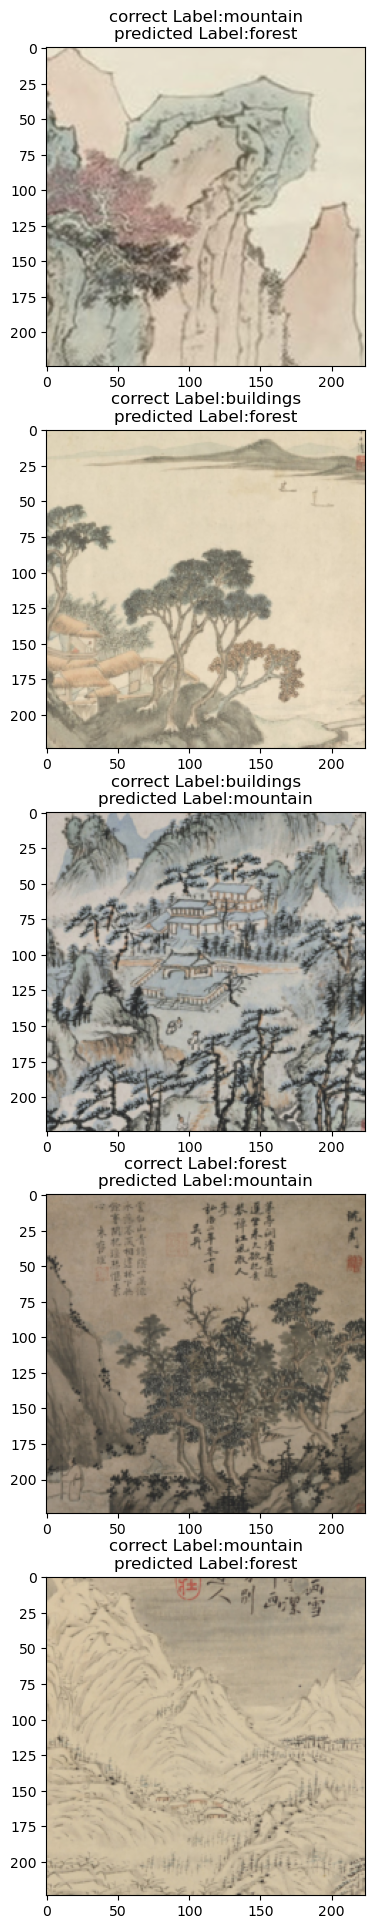

In [21]:
samples = 0
fig, ax = plt.subplots(5, figsize = (5, 24))
for X, y in art_test_dataset:
    if torch.cuda.is_available():
        X = X.cuda()
    output = model_vgg16(X)
    _, preds = torch.max(output, 1)
    predicts = preds.to('cpu')
    index = index = np.argwhere(y != predicts).flatten().numpy()
    for i in index:
        img = X.cpu().data[i].numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax[samples].imshow(img)
        ax[samples].set_title("correct Label:" + str(class_names[y[i]]) + "\npredicted Label:" + str(class_names[predicts[i]]),fontsize = 12)
        samples += 1
        if samples > 4:
            break
plt.show()

### Pre-trained on intel image dataset:

#### freezed model on intel dataset:

In [84]:
model_vgg16_intel = models.vgg16(weights='DEFAULT').to(device)
for param in model_vgg16_intel.features.parameters():
    param.requires_grad = False

In [85]:
model_vgg16_intel.classifier[6] = nn.Linear(model_vgg16_intel.classifier[6].in_features, len(class_names)).to(device)
vgg16_intel_criterion = nn.CrossEntropyLoss()
vgg16_intel_optimizer = torch.optim.Adam(model_vgg16_intel.classifier.parameters(), lr=0.0005)

In [ ]:
epochs = 10
best_acc = 0.0

for epoch in range(epochs):
    # train data
    model_vgg16_intel.train()  
    for X, y in train_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # zero the parameter gradients
        vgg16_intel_optimizer.zero_grad()
        # forward
        outputs = model_vgg16_intel(X)
        loss = vgg16_intel_criterion(outputs, y)
        # backward + optimize 
        loss.backward()
        vgg16_intel_optimizer.step()

    # valid data
    valid_loss = 0.0
    correct = 0
    model_vgg16_intel.eval()
    # Iterate over data.
    for X, y in test_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # forward
        outputs = model_vgg16_intel(X)
        loss = vgg16_intel_criterion(outputs, y)
        valid_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y) 
    
    epoch_loss = valid_loss / len(test_dataset)
    epoch_acc = correct / (len(test_dataset) * 32)
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f' Loss: {epoch_loss:.4f} Acc: {epoch_acc:.3f}')
    if epoch_acc >= best_acc:
        best_acc = epoch_acc
        torch.save(model_vgg16_intel.state_dict(), 'freezed_vgg16_intel_model.pt')


Epoch 1/10
 Loss: 0.0418 Acc: 0.990
Epoch 2/10
 Loss: 0.0552 Acc: 0.992
Epoch 3/10
 Loss: 0.0657 Acc: 0.989
Epoch 4/10
 Loss: 0.0325 Acc: 0.991
Epoch 5/10
 Loss: 0.0278 Acc: 0.992
Epoch 6/10
 Loss: 0.0301 Acc: 0.994
Epoch 7/10
 Loss: 0.0481 Acc: 0.994
Epoch 8/10
 Loss: 0.0255 Acc: 0.994
Epoch 9/10
 Loss: 0.0211 Acc: 0.992
Epoch 10/10
 Loss: 0.0313 Acc: 0.993


#### Unfreezed model on intel dataset:

In [26]:
model_vgg16_intel.load_state_dict(torch.load('freezed_vgg16_intel_model.pt'))
model_vgg16_intel = model_vgg16_intel.to(device)
for param in model_vgg16_intel.parameters():
    param.requires_grad = True
unfreeze_criterion = nn.CrossEntropyLoss()
unfreeze_optimizer = torch.optim.SGD(model_vgg16_intel.parameters(), lr=0.001, momentum=0.9)

In [27]:
epochs = 10
best_acc = 0.0
for epoch in range(epochs):
    # train data
    model_vgg16_intel.train()  
    for X, y in train_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # zero the parameter gradients
        unfreeze_optimizer.zero_grad()
        # forward
        outputs = model_vgg16_intel(X)
        loss = unfreeze_criterion(outputs, y)
        # backward + optimize 
        loss.backward()
        unfreeze_optimizer.step()

    # valid data
    valid_loss = 0.0
    correct = 0
    model_vgg16_intel.eval()
    # Iterate over data.
    for X, y in test_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # forward
        outputs = model_vgg16_intel(X)
        loss = unfreeze_criterion(outputs, y)
        valid_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y) 
    
    epoch_loss = valid_loss / len(test_dataset)
    epoch_acc = correct / (len(test_dataset) * 32)
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f' Loss: {epoch_loss:.4f} Acc: {epoch_acc:.3f}')
    if epoch_acc >= best_acc:
        best_acc = epoch_acc
        torch.save(model_vgg16_intel.state_dict(), 'unfreezed_vgg16_intel_model.pt')


Epoch 1/10
 Loss: 0.0155 Acc: 0.993
Epoch 2/10
 Loss: 0.0176 Acc: 0.994
Epoch 3/10
 Loss: 0.0160 Acc: 0.994
Epoch 4/10
 Loss: 0.0658 Acc: 0.984
Epoch 5/10
 Loss: 0.0221 Acc: 0.994
Epoch 6/10
 Loss: 0.0257 Acc: 0.992
Epoch 7/10
 Loss: 0.0161 Acc: 0.994
Epoch 8/10
 Loss: 0.0173 Acc: 0.994
Epoch 9/10
 Loss: 0.0198 Acc: 0.993
Epoch 10/10
 Loss: 0.0194 Acc: 0.992


#### Trained on curated dataset:

In [78]:
model_vgg16_trained = models.vgg16(weights='DEFAULT').to(device)
model_vgg16_trained.classifier[6] = nn.Linear(model_vgg16_trained.classifier[6].in_features, len(art_names)).to(device)
model_vgg16_trained.load_state_dict(torch.load('unfreezed_vgg16_intel_model.pt'))
model_vgg16_trained = model_vgg16_trained.to(device)
trained_criterion = nn.CrossEntropyLoss()
trained_optimizer = torch.optim.SGD(model_vgg16_trained.parameters(), lr=0.001, momentum=0.9)

In [79]:
epochs = 20
best_acc = 0.0
trained_vgg16_losses = []
trained_vgg16_corrects = []

for epoch in range(epochs):
    # train data
    model_vgg16_trained.train()  
    for X, y in art_train_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # zero the parameter gradients
        trained_optimizer.zero_grad()
        # forward
        outputs = model_vgg16_trained(X)
        loss = trained_criterion(outputs, y)
        # backward + optimize 
        loss.backward()
        trained_optimizer.step()

    # valid data
    valid_loss = 0.0
    correct = 0
    model_vgg16_trained.eval()
    # Iterate over data.
    for X, y in art_test_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # forward
        outputs = model_vgg16_trained(X)
        loss = trained_criterion(outputs, y)
        valid_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y) 
    
    epoch_loss = valid_loss / len(art_test_dataset)
    epoch_acc = correct / (len(art_test_dataset) * 32)
    trained_vgg16_losses.append(epoch_loss)
    trained_vgg16_corrects.append(epoch_acc)
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f' Loss: {epoch_loss:.4f} Acc: {epoch_acc:.3f}')
    # stop training according to valid dataset
    if epoch_acc >= best_acc:
        best_acc = epoch_acc
        torch.save(model_vgg16_trained.state_dict(), 'trained_vgg16_model.pt')

Epoch 1/20
 Loss: 0.7992 Acc: 0.258
Epoch 2/20
 Loss: 0.6000 Acc: 0.352
Epoch 3/20
 Loss: 0.2911 Acc: 0.422
Epoch 4/20
 Loss: 0.7408 Acc: 0.297
Epoch 5/20
 Loss: 0.4507 Acc: 0.406
Epoch 6/20
 Loss: 0.2637 Acc: 0.406
Epoch 7/20
 Loss: 0.3708 Acc: 0.391
Epoch 8/20
 Loss: 0.5309 Acc: 0.367
Epoch 9/20
 Loss: 0.3149 Acc: 0.422
Epoch 10/20
 Loss: 0.3713 Acc: 0.414
Epoch 11/20
 Loss: 0.4837 Acc: 0.383
Epoch 12/20
 Loss: 0.2510 Acc: 0.414
Epoch 13/20
 Loss: 0.4450 Acc: 0.406
Epoch 14/20
 Loss: 0.5856 Acc: 0.398
Epoch 15/20
 Loss: 0.6484 Acc: 0.352
Epoch 16/20
 Loss: 0.4600 Acc: 0.406
Epoch 17/20
 Loss: 0.3449 Acc: 0.383
Epoch 18/20
 Loss: 0.3799 Acc: 0.438
Epoch 19/20
 Loss: 0.4867 Acc: 0.391
Epoch 20/20
 Loss: 0.3629 Acc: 0.406


#### Evaluation and samples:

In [147]:
model_vgg16_trained.load_state_dict(torch.load('trained_vgg16_model.pt'))
model_vgg16_trained = model_vgg16_trained.to(device)

In [148]:
correct = 0
model_vgg16_trained.eval()    
for X, y in art_test_dataset:
    if torch.cuda.is_available():
        X, y = X.cuda(), y.cuda()
    # forward data
    output = model_vgg16_trained(X)
    _, preds = torch.max(output, 1)
    correct += torch.sum(preds == y)
accuracy = correct / (len(art_test_dataset) * 32)
print('The evaluation of the accuracy of vgg16 model pre-trained on intel image dataset is {:.3f}'.format(accuracy))

The evaluation of the accuracy of vgg16 model pre-trained on intel image dataset is 0.438


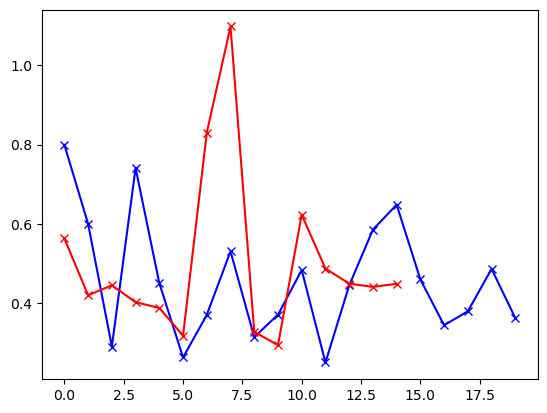

In [115]:
plt.plot(trained_vgg16_losses, '-bx')
plt.plot(vgg16_losses, '-rx')

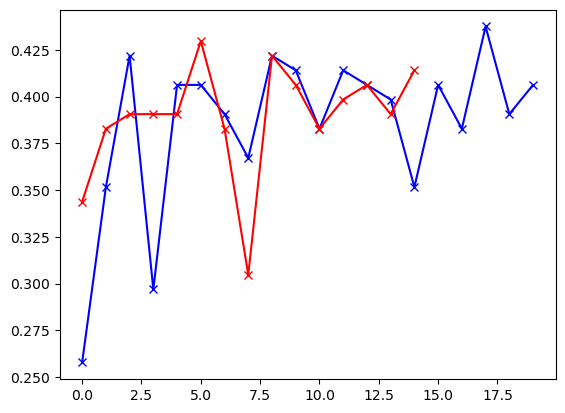

In [124]:
plot_trained_vgg16_corrects = [x.to('cpu') for x in trained_vgg16_corrects]
plot_vgg16_corrects = [x.to('cpu') for x in vgg16_corrects]
plt.plot(plot_trained_vgg16_corrects, '-bx')
plt.plot(plot_vgg16_corrects, '-rx')

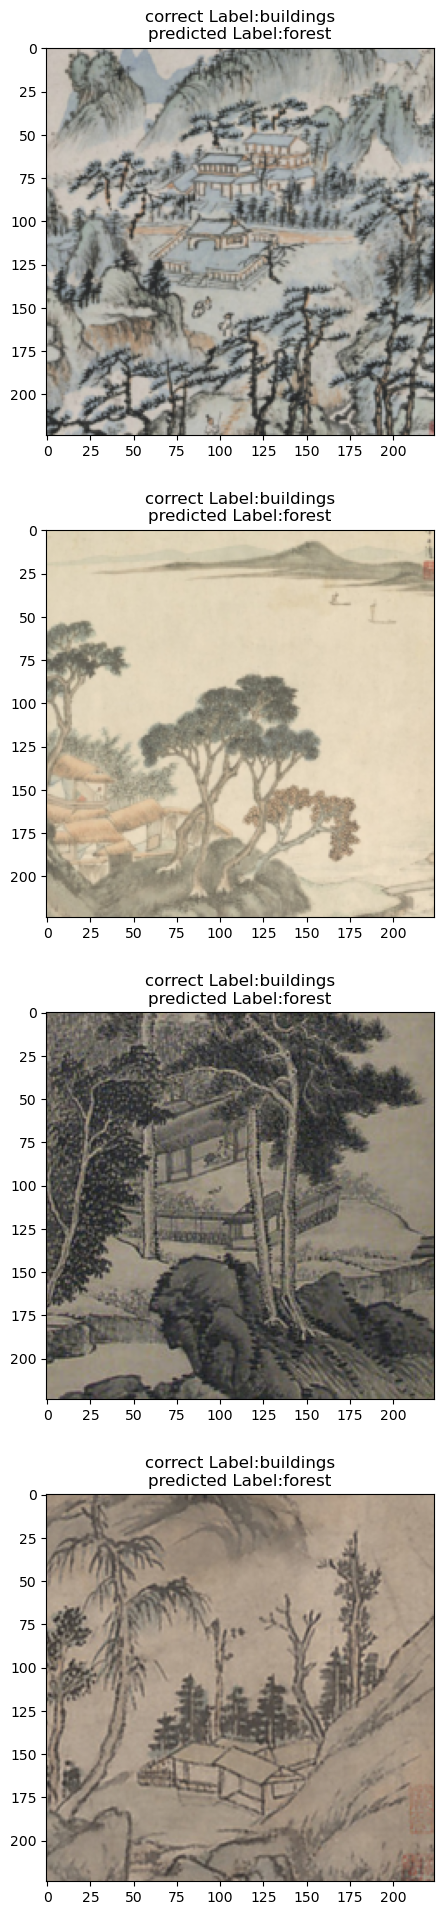

In [40]:
samples = 0
fig, ax = plt.subplots(4, figsize = (5, 24))
for X, y in art_test_dataset:
    if torch.cuda.is_available():
        X = X.cuda()
    output = model_vgg16_trained(X)
    _, preds = torch.max(output, 1)
    predicts = preds.to('cpu')
    index = index = np.argwhere(y != predicts).flatten().numpy()
    for i in index:
        img = X.cpu().data[i].numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax[samples].imshow(img)
        ax[samples].set_title("correct Label:" + str(class_names[y[i]]) + "\npredicted Label:" + str(class_names[predicts[i]]),fontsize = 12)
        samples += 1
        if samples > 4:
            break
plt.show()

## Model Resnet18: 

### Transfer learning directly:

#### freezed model:

In [41]:
model_resnet18 = models.resnet18(weights='DEFAULT').to(device)
for param in model_resnet18.parameters():
    param.requires_grad = False
model_resnet18.fc = nn.Linear(512, len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet18.parameters(), lr=0.0005)

In [43]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
epochs = 20
best_acc = 0.0

for epoch in range(epochs):
    # train data
    model_resnet18.train()  
    for X, y in art_train_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        outputs = model_resnet18(X)
        loss = criterion(outputs, y)
        # backward + optimize 
        loss.backward()
        optimizer.step()

    # valid data
    valid_loss = 0.0
    correct = 0
    model_resnet18.eval()
    # Iterate over data.
    for X, y in art_test_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # forward
        outputs = model_resnet18(X)
        loss = criterion(outputs, y)
        valid_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y) 
    
    epoch_loss = valid_loss / len(art_test_dataset)
    epoch_acc = correct / (len(art_test_dataset) * 32)
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f' Loss: {epoch_loss:.4f} Acc: {epoch_acc:.3f}')
    if epoch_acc >= best_acc:
        best_acc = epoch_acc
        torch.save(model_resnet18.state_dict(), 'freezed_resnet18_model.pt')

Epoch 1/20
 Loss: 1.3016 Acc: 0.148
Epoch 2/20
 Loss: 1.1066 Acc: 0.203
Epoch 3/20
 Loss: 1.0858 Acc: 0.195
Epoch 4/20
 Loss: 1.0657 Acc: 0.227
Epoch 5/20
 Loss: 0.9632 Acc: 0.273
Epoch 6/20
 Loss: 1.0306 Acc: 0.234
Epoch 7/20
 Loss: 0.9307 Acc: 0.281
Epoch 8/20
 Loss: 0.8638 Acc: 0.297
Epoch 9/20
 Loss: 0.8858 Acc: 0.297
Epoch 10/20
 Loss: 0.8732 Acc: 0.305
Epoch 11/20
 Loss: 0.8668 Acc: 0.297
Epoch 12/20
 Loss: 0.8198 Acc: 0.305
Epoch 13/20
 Loss: 0.8575 Acc: 0.305
Epoch 14/20
 Loss: 0.7695 Acc: 0.312
Epoch 15/20
 Loss: 0.8054 Acc: 0.305
Epoch 16/20
 Loss: 0.7612 Acc: 0.312
Epoch 17/20
 Loss: 0.7631 Acc: 0.312
Epoch 18/20
 Loss: 0.7640 Acc: 0.312
Epoch 19/20
 Loss: 0.7393 Acc: 0.305
Epoch 20/20
 Loss: 0.7214 Acc: 0.312


#### Unfreeze model:

In [125]:
model_resnet18.load_state_dict(torch.load('freezed_resnet18_model.pt'))
model_resnet18 = model_resnet18.to(device)
for param in model_resnet18.parameters():
    param.requires_grad = True
unfreeze_criterion = nn.CrossEntropyLoss()
unfreeze_optimizer = torch.optim.SGD(model_resnet18.parameters(), lr=0.001, momentum=0.9)

In [126]:
epochs = 15
best_acc = 0.0
resnet18_losses = []
resnet18_corrects = []

for epoch in range(epochs):
    # train data
    model_resnet18.train()  
    for X, y in art_train_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # zero the parameter gradients
        unfreeze_optimizer.zero_grad()
        # forward
        outputs = model_resnet18(X)
        loss = unfreeze_criterion(outputs, y)
        # backward + optimize 
        loss.backward()
        unfreeze_optimizer.step()

    # valid data
    valid_loss = 0.0
    correct = 0
    model_resnet18.eval()
    # Iterate over data.
    for X, y in art_test_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # forward
        outputs = model_resnet18(X)
        loss = unfreeze_criterion(outputs, y)
        valid_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y) 
    
    epoch_loss = valid_loss / len(art_test_dataset)
    epoch_acc = correct / (len(art_test_dataset) * 32)
    resnet18_losses.append(epoch_loss)
    resnet18_corrects.append(epoch_acc)
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f' Loss: {epoch_loss:.4f} Acc: {epoch_acc:.3f}')
    # stop training according to valid dataset
    if epoch_acc >= best_acc:
        best_acc = epoch_acc
        torch.save(model_resnet18.state_dict(), 'unfreeze_resnet18_model.pt')

Epoch 1/15
 Loss: 0.7171 Acc: 0.289
Epoch 2/15
 Loss: 0.6154 Acc: 0.344
Epoch 3/15
 Loss: 0.5342 Acc: 0.375
Epoch 4/15
 Loss: 0.4946 Acc: 0.383
Epoch 5/15
 Loss: 0.4840 Acc: 0.406
Epoch 6/15
 Loss: 0.4496 Acc: 0.383
Epoch 7/15
 Loss: 0.4836 Acc: 0.391
Epoch 8/15
 Loss: 0.4406 Acc: 0.383
Epoch 9/15
 Loss: 0.3824 Acc: 0.398
Epoch 10/15
 Loss: 0.4817 Acc: 0.367
Epoch 11/15
 Loss: 0.4318 Acc: 0.383
Epoch 12/15
 Loss: 0.5420 Acc: 0.375
Epoch 13/15
 Loss: 0.5845 Acc: 0.359
Epoch 14/15
 Loss: 0.5768 Acc: 0.375
Epoch 15/15
 Loss: 0.4866 Acc: 0.391


#### Evaluation and samples:

In [47]:
model_resnet18.load_state_dict(torch.load('unfreeze_resnet18_model.pt'))
model_resnet18 = model_resnet18.to(device)

In [48]:
correct = 0
model_resnet18.eval()    
for X, y in art_test_dataset:
    if torch.cuda.is_available():
        X, y = X.cuda(), y.cuda()
    # forward data
    output = model_resnet18(X)
    _, preds = torch.max(output, 1)
    correct += torch.sum(preds == y)
accuracy = correct / (len(art_test_dataset) * 32)
print('The evaluation of the accuracy of resnet18 model is {:.3f}'.format(accuracy))

The evaluation of the accuracy of resnet18 model is 0.398


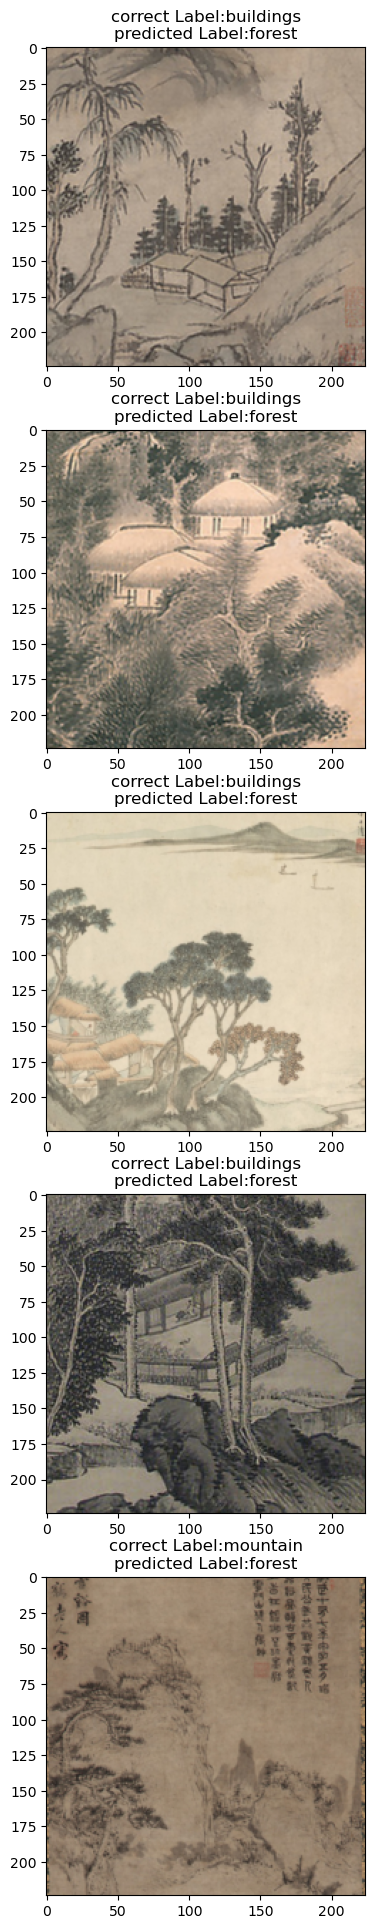

In [52]:
samples = 0
fig, ax = plt.subplots(5, figsize = (6, 24))
for X, y in art_test_dataset:
    if torch.cuda.is_available():
        X = X.cuda()
    output = model_resnet18(X)
    _, preds = torch.max(output, 1)
    predicts = preds.to('cpu')
    index = np.argwhere(y != predicts).flatten().numpy()
    for i in index:
        img = X.cpu().data[i].numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax[samples].imshow(img)
        ax[samples].set_title("correct Label:" + str(class_names[y[i]]) + "\npredicted Label:" + str(class_names[predicts[i]]),fontsize = 12)
        samples += 1
        if samples > 4:
            break
    if samples > 4:
        break       
plt.show()

### Pretrained on intel image dataset:

#### freezed:

In [53]:
model_resnet18_intel = models.resnet18(weights='DEFAULT').to(device)
for param in model_resnet18_intel.parameters():
    param.requires_grad = False
model_resnet18_intel.fc = nn.Linear(512, len(class_names)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_resnet18_intel.parameters(), lr=0.0005)

In [54]:
epochs = 10
best_acc = 0.0

for epoch in range(epochs):
    # train data
    model_resnet18_intel.train()  
    for X, y in train_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward
        outputs = model_resnet18_intel(X)
        loss = criterion(outputs, y)
        # backward + optimize 
        loss.backward()
        optimizer.step()

    # valid data
    valid_loss = 0.0
    correct = 0
    model_resnet18_intel.eval()
    # Iterate over data.
    for X, y in test_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # forward
        outputs = model_resnet18_intel(X)
        loss = criterion(outputs, y)
        valid_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y) 
    
    epoch_loss = valid_loss / len(test_dataset)
    epoch_acc = correct / (len(test_dataset) * 32)
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f' Loss: {epoch_loss:.4f} Acc: {epoch_acc:.3f}')
    # stop training according to valid dataset
    if epoch_acc >= best_acc:
        best_acc = epoch_acc
        torch.save(model_resnet18_intel.state_dict(), 'freezed_resnet18_intel_model.pt')

Epoch 1/10
 Loss: 0.0912 Acc: 0.985
Epoch 2/10
 Loss: 0.0517 Acc: 0.988
Epoch 3/10
 Loss: 0.0422 Acc: 0.988
Epoch 4/10
 Loss: 0.0374 Acc: 0.986
Epoch 5/10
 Loss: 0.0336 Acc: 0.988
Epoch 6/10
 Loss: 0.0282 Acc: 0.989
Epoch 7/10
 Loss: 0.0264 Acc: 0.989
Epoch 8/10
 Loss: 0.0341 Acc: 0.986
Epoch 9/10
 Loss: 0.0240 Acc: 0.990
Epoch 10/10
 Loss: 0.0240 Acc: 0.989


#### Unfreezed:

In [55]:
model_resnet18_intel.load_state_dict(torch.load('freezed_resnet18_intel_model.pt'))
model_resnet18_intel = model_resnet18_intel.to(device)
for param in model_resnet18_intel.parameters():
    param.requires_grad = True
unfreeze_criterion = nn.CrossEntropyLoss()
unfreeze_optimizer = torch.optim.SGD(model_resnet18_intel.parameters(), lr=0.001, momentum=0.9)

In [56]:
epochs = 10
best_acc = 0.0

for epoch in range(epochs):
    # train data
    model_resnet18_intel.train()  
    for X, y in train_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # zero the parameter gradients
        unfreeze_optimizer.zero_grad()
        # forward
        outputs = model_resnet18_intel(X)
        loss = unfreeze_criterion(outputs, y)
        # backward + optimize 
        loss.backward()
        unfreeze_optimizer.step()

    # valid data
    valid_loss = 0.0
    correct = 0
    model_resnet18_intel.eval()
    # Iterate over data.
    for X, y in test_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # forward
        outputs = model_resnet18_intel(X)
        loss = unfreeze_criterion(outputs, y)
        valid_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y) 
    
    epoch_loss = valid_loss / len(test_dataset)
    epoch_acc = correct / (len(test_dataset) * 32)
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f' Loss: {epoch_loss:.4f} Acc: {epoch_acc:.3f}')
    if epoch_acc >= best_acc:
        best_acc = epoch_acc
        torch.save(model_resnet18_intel.state_dict(), 'unfreezed_resnet18_intel_model.pt')

Epoch 1/10
 Loss: 0.0170 Acc: 0.992
Epoch 2/10
 Loss: 0.0138 Acc: 0.994
Epoch 3/10
 Loss: 0.0152 Acc: 0.992
Epoch 4/10
 Loss: 0.0105 Acc: 0.995
Epoch 5/10
 Loss: 0.0113 Acc: 0.994
Epoch 6/10
 Loss: 0.0113 Acc: 0.994
Epoch 7/10
 Loss: 0.0099 Acc: 0.995
Epoch 8/10
 Loss: 0.0090 Acc: 0.995
Epoch 9/10
 Loss: 0.0102 Acc: 0.993
Epoch 10/10
 Loss: 0.0099 Acc: 0.994


#### Trained on curated dataset:

In [153]:
model_resnet18_trained = models.resnet18(weights='DEFAULT').to(device)
model_resnet18_trained.fc = nn.Linear(512, len(class_names)).to(device)
model_resnet18_trained.load_state_dict(torch.load('unfreezed_resnet18_intel_model.pt'))
model_resnet18_trained = model_resnet18_trained.to(device)
trained_criterion = nn.CrossEntropyLoss()
trained_optimizer = torch.optim.SGD(model_resnet18_trained.parameters(), lr=0.001, momentum=0.8)

In [154]:
epochs = 20
best_acc = 0.0
trained_resnet18_losses = []
trained_resnet18_corrects = []

for epoch in range(epochs):
    # train data
    model_resnet18_trained.train()  
    for X, y in art_train_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # zero the parameter gradients
        trained_optimizer.zero_grad()
        # forward
        outputs = model_resnet18_trained(X)
        loss = trained_criterion(outputs, y)
        # backward + optimize 
        loss.backward()
        trained_optimizer.step()

    # valid data
    valid_loss = 0.0
    correct = 0
    model_resnet18_trained.eval()
    # Iterate over data.
    for X, y in art_test_dataset:
        if torch.cuda.is_available():
            X, y = X.cuda(), y.cuda()
        # forward
        outputs = model_resnet18_trained(X)
        loss = trained_criterion(outputs, y)
        valid_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == y) 
    
    epoch_loss = valid_loss / len(art_test_dataset)
    epoch_acc = correct / (len(art_test_dataset) * 32)
    trained_resnet18_losses.append(epoch_loss)
    trained_resnet18_corrects.append(epoch_acc)
    print(f'Epoch {epoch + 1}/{epochs}')
    print(f' Loss: {epoch_loss:.4f} Acc: {epoch_acc:.3f}')
    if epoch_acc >= best_acc:
        best_acc = epoch_acc
        torch.save(model_resnet18_trained.state_dict(), 'trained_resnet18_model.pt')

Epoch 1/20
 Loss: 0.9105 Acc: 0.297
Epoch 2/20
 Loss: 0.8500 Acc: 0.328
Epoch 3/20
 Loss: 0.5467 Acc: 0.375
Epoch 4/20
 Loss: 0.5895 Acc: 0.359
Epoch 5/20
 Loss: 0.4817 Acc: 0.391
Epoch 6/20
 Loss: 0.5676 Acc: 0.398
Epoch 7/20
 Loss: 0.3331 Acc: 0.406
Epoch 8/20
 Loss: 0.3413 Acc: 0.398
Epoch 9/20
 Loss: 0.4255 Acc: 0.383
Epoch 10/20
 Loss: 0.3411 Acc: 0.391
Epoch 11/20
 Loss: 0.2804 Acc: 0.414
Epoch 12/20
 Loss: 0.3380 Acc: 0.398
Epoch 13/20
 Loss: 0.2866 Acc: 0.414
Epoch 14/20
 Loss: 0.2412 Acc: 0.422
Epoch 15/20
 Loss: 0.3013 Acc: 0.398
Epoch 16/20
 Loss: 0.3834 Acc: 0.398
Epoch 17/20
 Loss: 0.2632 Acc: 0.398
Epoch 18/20
 Loss: 0.2894 Acc: 0.406
Epoch 19/20
 Loss: 0.3145 Acc: 0.398
Epoch 20/20
 Loss: 0.3647 Acc: 0.398


#### Evaluation and samples:

In [155]:
model_resnet18_trained.load_state_dict(torch.load('trained_resnet18_model.pt'))
model_resnet18_trained = model_resnet18_trained.to(device)

In [156]:
correct = 0
model_resnet18_trained.eval()    
for X, y in art_test_dataset:
    if torch.cuda.is_available():
        X, y = X.cuda(), y.cuda()
    # forward data
    output = model_resnet18_trained(X)
    _, preds = torch.max(output, 1)
    correct += torch.sum(preds == y)
accuracy = correct / (len(art_test_dataset) * 32)
print('The evaluation of the accuracy of resnet18 model pretrained on intel dataset is {:.3f}'.format(accuracy))

The evaluation of the accuracy of resnet18 model pretrained on intel dataset is 0.422


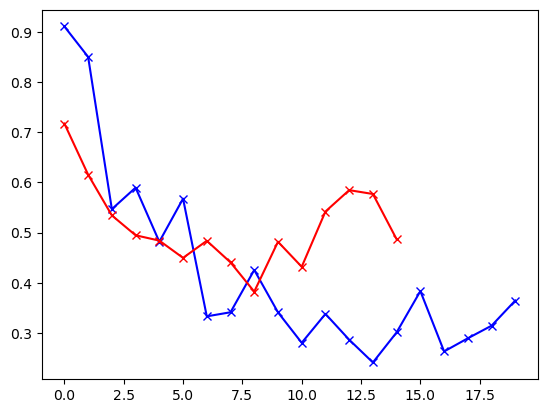

In [201]:
plt.plot(trained_resnet18_losses, '-bx')
plt.plot(resnet18_losses, '-rx')

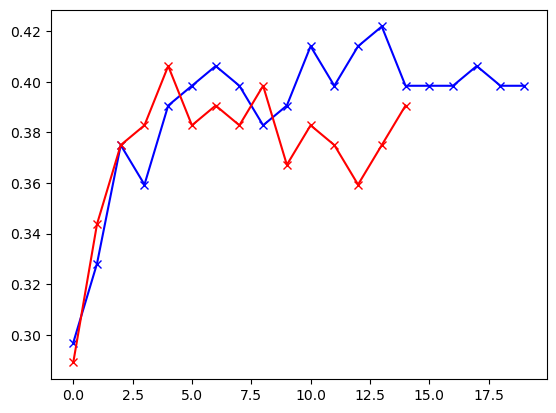

In [203]:
plot_trained_resnet18_corrects = [x.to('cpu') for x in trained_resnet18_corrects]
plot_resnet18_corrects = [x.to('cpu') for x in resnet18_corrects]
plt.plot(plot_trained_resnet18_corrects, '-bx')
plt.plot(plot_resnet18_corrects, '-rx')

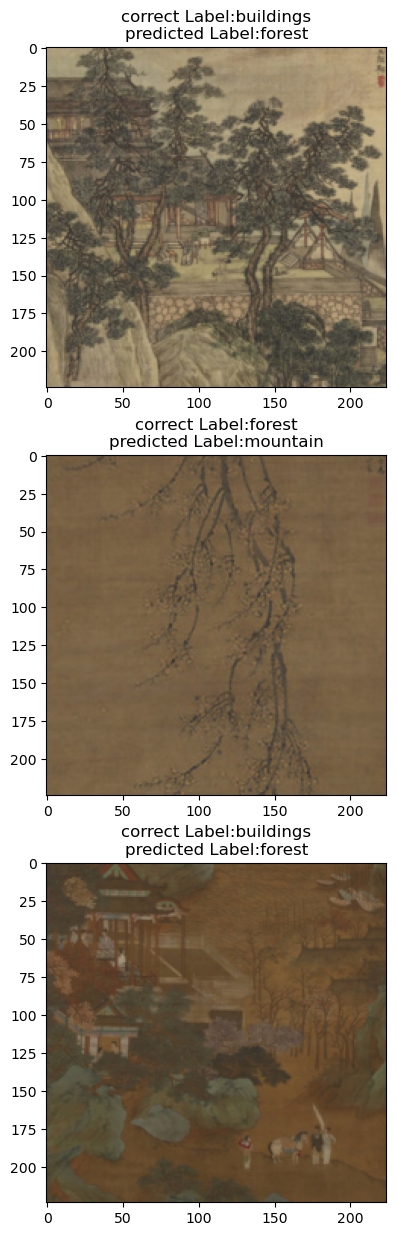

In [186]:
samples = 0
fig, ax = plt.subplots(3, figsize = (6, 15))
for X, y in art_test_dataset:
    if torch.cuda.is_available():
        X = X.cuda()
    output = model_resnet18(X)
    _, preds = torch.max(output, 1)
    predicts = preds.to('cpu')
    index = np.argwhere(y != predicts).flatten().numpy()
    for i in index:
        img = X.cpu().data[i].numpy().transpose((1,2,0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        ax[samples].imshow(img)
        ax[samples].set_title("correct Label:" + str(class_names[y[i]]) + "\npredicted Label:" + str(class_names[predicts[i]]),fontsize = 12)
        samples += 1
plt.show()